**Author**: stefan.m.janssen@gmail.com<br>
**Date**: 03 Aug 2016<br>
**language**: Python 3.0<br>
**conda enviroment**: micronota<br>
**license**: unlicensed<br>

# Sub-sample EMP
Currently the EMP comprises ~34k samples. Sometimes we want to operate on smaller sample numbers. Thus, we need to create several sub-samples for the EMP.
This notebook operates on the merged mapping file, filters samples accoring to some criteria (see below) and picks a specified numbers of samples, such that growing sub-samples do always contain all smaller sub-samples.

In [1]:
# a trick to make it transparent if executed on a barnacle node or on my machine with barnacles file system mounted to /media/barnacle
import socket
ROOT = "/media/barnacle/" if socket.gethostname() == 't440s' else "/"

In [2]:
%matplotlib inline

# make all necessary imports
import pandas as pd
import numpy as np
import sys
import random
import seaborn as sn
import matplotlib.pyplot as plt
import os

the next cell contains all parameters that might need to be changed

In [3]:
#filename of the input mapping file
file_mapping = ROOT + '/projects/emp/00-qiime-maps/merged/emp_qiime_mapping_latest.tsv'
#filename of the resulting mapping file
file_output = 'modMapping.txt'

#define seed to make results comparable between runs
random.seed(7)

#a sample must have at least 'minCounts' sequence reads to be included
minCounts = 1000 

#sub-set sizes
setSizes = [2000, 5000, 10000, 20000]

read in mapping file and filter accoring to three criteria:
1. a sample must contain a certain number of raw sequence reads
2. the sample must not be flagged as being a "Control"
3. study is considered as being OK (this is a result of a manual curation)

In [4]:
metadata = pd.read_csv(file_mapping, sep="\t", index_col=0, low_memory=False, dtype=str)
#it is more consistent to read all fields as strings and manually convert to numeric values for selected columns. Thus, roundtripping (read -> write) results in a nearly identical file.
metadata['sequences_per_sample'] = (pd.to_numeric(metadata['sequences_per_sample'], errors='coerce'))
metadata['study_ok'] = metadata['study_ok'].map(lambda x: np.True_ if x == 'True' else np.False_)

filtered_metadata = metadata[
    (metadata['sequences_per_sample'] >= minCounts) & #remove samples with low read numbers
    (metadata['empo_1'] != 'Control')               & #remove controls 
    (metadata['study_ok'] == np.True_)                #keep only studies that are manually curated and found OK
]

emp_metadata = metadata[
    (metadata['sequences_per_sample'].notnull()) & (metadata['sequences_per_sample'] != 0)
]

## actual logic to pick samples
Assume that we want to create more than one subsample set. However, they should form a strict hierarchy, i.e. a sample in a smaller set must also occure in any larger sets.

Furthermore, we want to make sure that each group is covered, since some groups are very large, others are small and might be otherwise subject of being missed. We divide the number of targeted samples by the number of existing groups (+ some corrections to end up with the right number of samples) and randomly sample within each group a sufficient number of samples.

If a group has more samples than needed samples should drawn from all existing studies in that group.

A larger subset is always initialized with the IDs of the next smaller subset, thus we make sure to form the hierarchy.

In [5]:
#convert np.infty to the actual number of total available samples in EMP satisfying the filtering criteria
setSizes = list(map(lambda x: x if x is not np.infty else filtered_metadata.shape[0], setSizes))

#make sure set sizes increase
setSizes = sorted(setSizes) 

subsets = {} #resulting object, will hold sample ID lists for the different subsets
for i in range(0, len(setSizes)):
    setSize = setSizes[i]
    subsets[setSize] = [] #list of used sample IDs is empty at the beginning
    if i == 0:
        unusedMetadata = filtered_metadata #if we compile the smallest subset, all available sample IDs can be used
    else:
        subsets[setSize].extend(subsets[setSizes[i-1]]) #a larger subset must always contain all sample IDs from a smaller subset
        unusedMetadata = filtered_metadata[~filtered_metadata.index.isin(subsets[setSizes[i-1]])] #make sure sample IDs are not added twice
    
    empo_groupped = unusedMetadata.groupby(['empo_0','empo_1','empo_2','empo_3']) #group available sample IDs to ensure that each group is covered in the resulting subset
    empo_seenGroups = 0
    for empo_n,empo_g in sorted(empo_groupped, key=lambda x: len(x[1])): #iterate through the groups, ascendingly by number of available samples
        empo_size = (setSize - len(subsets[setSize])) / (len(empo_groupped) - empo_seenGroups) #define optimal number of samples for each group
        if empo_g.shape[0] < empo_size:
            toBeAdded = list(empo_g.index) #if group contains fewer samples than 'size', all sample IDs are added
        else:
            toBeAdded = []
            study_seenGroups = 0
            study_grouped = empo_g.groupby('study_id')
            for study_n, study_g in sorted(study_grouped, key=lambda x: len(x[1])):
                study_size = (empo_size - len(toBeAdded)) / (len(study_grouped) - study_seenGroups)
                if study_g.shape[0] < study_size:
                    toBeAdded.extend(list(study_g.index))
                else:
                    toBeAdded.extend(random.sample(list(study_g.index), int(study_size)))
                study_seenGroups += 1
        subsets[setSize].extend(toBeAdded)
        empo_seenGroups += 1

Write output by first merging new columns to the original metadata and than only write those to a output file.

In [6]:
newColumnNames = []

#add a column to mark samples that are in EMP (i.e. samples that have some counts)
newColumnNames.append('all_emp')
metadata[newColumnNames[-1]] = metadata.index.isin(emp_metadata.index)

#add a column to mark samples that satisfy our filtering criteria
newColumnNames.append('qc_filtered')
metadata[newColumnNames[-1]] = metadata.index.isin(filtered_metadata.index)

#add new columns to the orginal mapping file
for size in sorted(subsets.keys()):
    newColumnNames.append('subset_'+str(size))
    metadata[newColumnNames[-1]] = metadata.index.isin(subsets[size])

#re-convert field to integer values and "" instead of np.float_
metadata['sequences_per_sample'] = metadata['sequences_per_sample'].map(lambda x: "" if np.isnan(x) else str(int(x)))

metadata[newColumnNames].to_csv(open(file_output, "w"), sep="\t")
# metadata.to_csv(open(file_output, "w"), sep="\t") #if we want to save the complete mapping file

print("Result is stored in '%s'" % (os.path.abspath(file_output)))

Result is stored in '/media/Daten/KnightLab/EMP/modMapping.txt'


## diagnostics
Collect data for diagnostics

In [7]:
singles = []
study_singles = []
sets = {'everything': metadata,
        'all_emp': emp_metadata,
        'qc_filtered': filtered_metadata}
ordering = ['everything', 'all_emp', 'qc_filtered']
for setSize in sorted(subsets.keys()):
    name = 'subset_' + str(setSize)
    sets[name] = metadata[metadata[name]]
    ordering.append(name)

for setName in sets.keys():
    x = []
    for n,g in sets[setName].groupby(['empo_0','empo_1','empo_2','empo_3']):
        x.append({'samples': g.shape[0], 
                  'studies': len(g.groupby('study_id')),
                  'group': n[3],
                  'set': setName})
    singles.append(pd.DataFrame(x))
    
    study_x = []
    for n,g in metadata.groupby(['study_id']):
        study_x.append({'samples': sets[setName][sets[setName]['study_id'] == n].shape[0],
                        'study': n,
                        'set': setName})
    study_singles.append(pd.DataFrame(study_x))

data = pd.concat(singles)
study_data = pd.concat(study_singles)

## visualize data
Two quick sanity checks:

We expect the sub-set distribution of 'number samples' (first plot) to follow the one of the 'filtered' data-set, but be cut off at a certain level such that only the lower part remains.

The distribution of 'number studies' (second plot) should be identical to the one of the 'filtered' data-set.

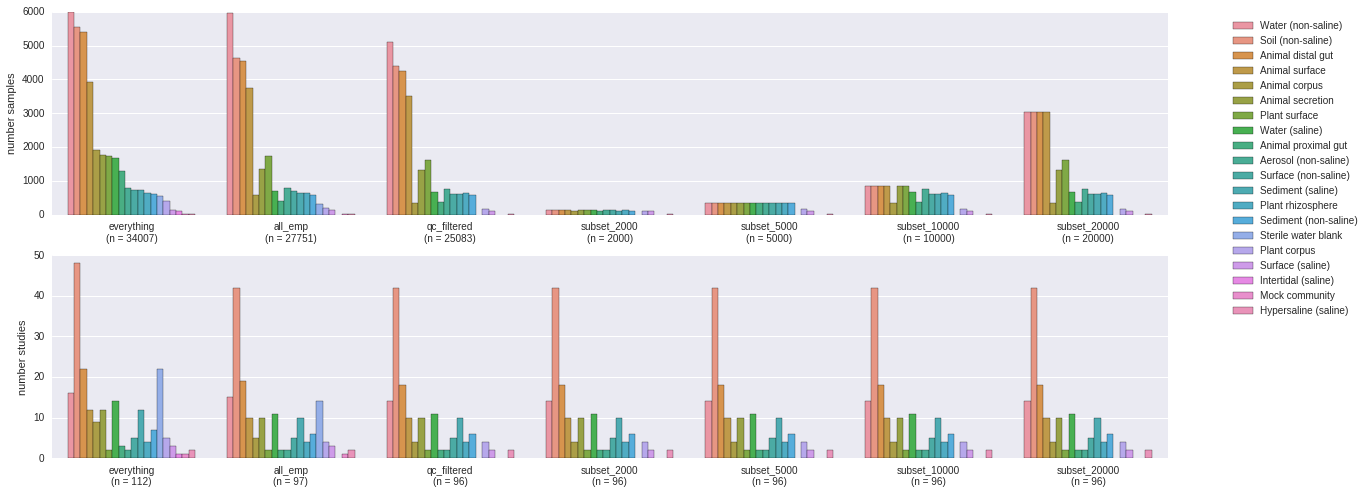

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
sn.barplot(x="set", 
           y="samples", 
           hue="group", 
           data=data, 
           order=ordering,
           hue_order=list(data[data.set == 'everything'].sort_values('samples', ascending=False).group),
           ax=ax[0],
          )
l = ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2)
l = ax[0].set_ylabel("number samples")
l = ax[0].set_xlabel("")
l = ax[0].set_xticklabels([ s + "\n(n = " + str(sets[s].shape[0]) + ")" for s in ordering ])

sn.barplot(x="set", 
           y="studies", 
           hue="group", 
           data=data, 
           order=ordering,
           hue_order=list(data[data.set == 'everything'].sort_values('samples', ascending=False).group),
           ax=ax[1],
          )
l = ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2)
l.remove()
l = ax[1].set_ylabel("number studies")
l = ax[1].set_xlabel("")
l = ax[1].set_xticklabels([ s + "\n(n = " + str(len(sets[s].groupby('study_id'))) + ")" for s in ordering ])

We want to make sure that samples drawn within a EMPO group are equally (not proportionally) drawn from the studies that fall into the EMPO group. We should observe the same trimming of distributions as on the above graph 'number samples'. However, the picture gets blurred due to the fact that the overall number of samples to be drawn is dictated by the EMPO category.

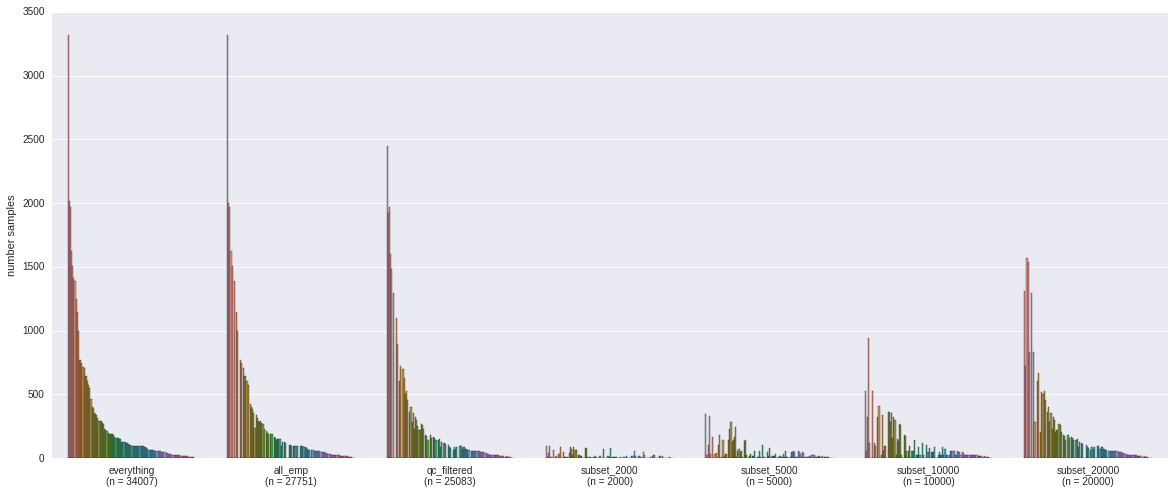

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sn.barplot(x="set",
           y="samples",
           hue="study",
           data=study_data,
           order=ordering,
           ax = ax,
           hue_order=list(study_data[study_data.set == 'everything'].sort_values('samples', ascending=False).study),
          )
l = ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
l.remove()
l = ax.set_ylabel("number samples")
l = ax.set_xlabel("")
l = ax.set_xticklabels([ s + "\n(n = " + str(sets[s].shape[0]) + ")" for s in ordering ])